[*********************100%%**********************]  1 of 1 completed


2/2 [==============================] - 1s 10ms/step


C:\Users\Admin\AppData\Local\Temp\ipykernel_40456\688101783.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


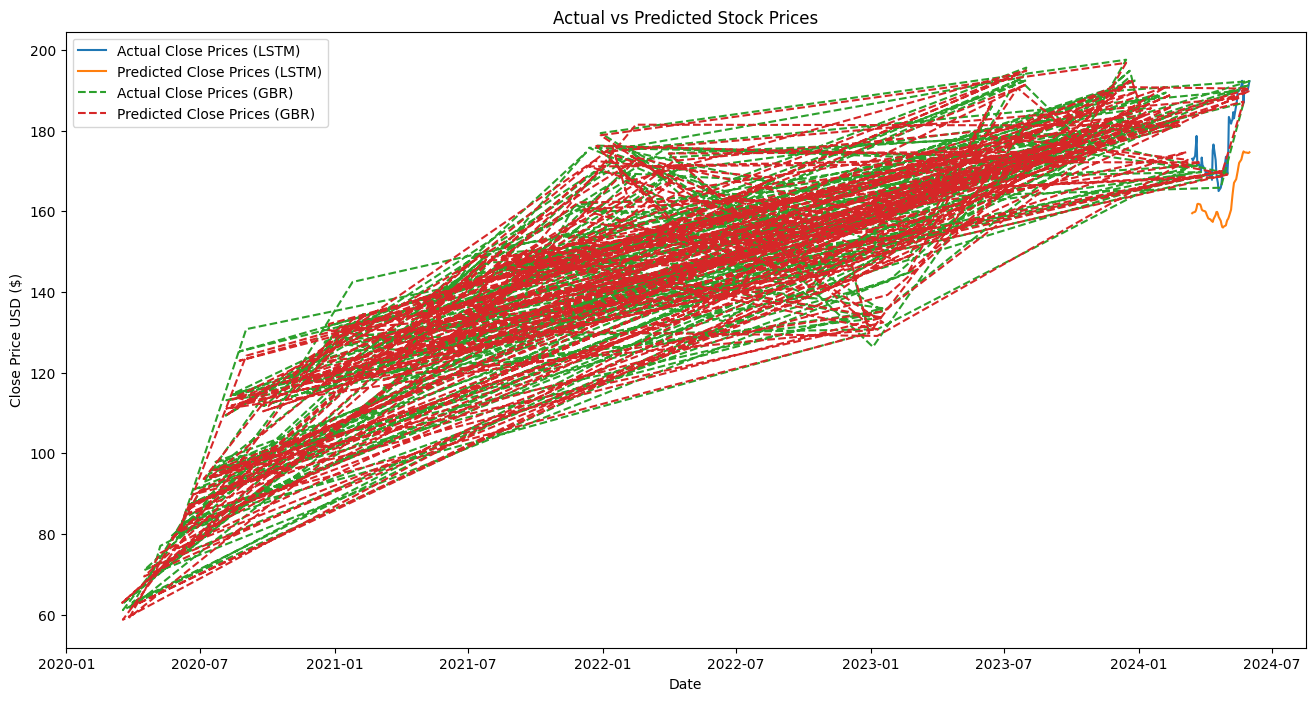

LSTM RMSE: 14.696511182782983
Gradient Boosting MSE: 8.543001753771062, MAE: 2.1510014686795693


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Download historical data for AAPL
df = yf.download('AAPL', start='2020-01-01', end=pd.to_datetime('today'))

# LSTM Model
data = df.filter(['Close'])
dataset = data.values
training_data_len = int(np.ceil(len(dataset) * .95))
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

train_data = scaled_data[0:int(training_data_len), :]
x_train, y_train = [], []
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size=1, epochs=1)

test_data = scaled_data[training_data_len - 60:, :]
x_test, y_test = [], dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse_lstm = np.sqrt(np.mean(((predictions - y_test) ** 2)))

train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

# Gradient Boosting Model
df['10_day_MA'] = df['Adj Close'].rolling(window=10).mean()
df['20_day_MA'] = df['Adj Close'].rolling(window=20).mean()
df['50_day_MA'] = df['Adj Close'].rolling(window=50).mean()
df['Daily_Return'] = df['Adj Close'].pct_change()
df.dropna(inplace=True)
X = df[['10_day_MA', '20_day_MA', '50_day_MA', 'Daily_Return']]
y = df['Adj Close']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

param_grid = {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1], 'max_depth': [3, 5]}
gbr = GradientBoostingRegressor()
grid_search = GridSearchCV(estimator=gbr, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, y_train)
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test_scaled)
mse_gbr = mean_squared_error(y_test, y_pred)
mae_gbr = mean_absolute_error(y_test, y_pred)

# Plot comparison
plt.figure(figsize=(16, 8))

# LSTM predictions
plt.plot(valid.index, valid['Close'], label='Actual Close Prices (LSTM)')
plt.plot(valid.index, valid['Predictions'], label='Predicted Close Prices (LSTM)')

# Gradient Boosting predictions
plt.plot(y_test.index, y_test, label='Actual Close Prices (GBR)', linestyle='--')
plt.plot(y_test.index, y_pred, label='Predicted Close Prices (GBR)', linestyle='--')

plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.legend()
plt.show()

# Print evaluation metrics
print(f"LSTM RMSE: {rmse_lstm}")
print(f"Gradient Boosting MSE: {mse_gbr}, MAE: {mae_gbr}")